# CS584  — Generative Learning

Author: Asad Abdullah

In [1]:


!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, recall_score, precision_score, f1_score,
    precision_recall_curve, auc
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"Using fixed random seed: {RANDOM_SEED}")



Using fixed random seed: 42


In [2]:
# =====================================================
# DATASET LOADING
# =====================================================

# Load Iris (continuous)
iris = fetch_ucirepo(id=53)
X_iris_full, y_iris_full = iris.data.features, iris.data.targets

# Binary subset: Iris-setosa vs Iris-versicolor
# mask = (y_iris_full['class'] == 'Iris-setosa') | (y_iris_full['class'] == 'Iris-versicolor')
#X_iris_binary = X_iris_full[mask].reset_index(drop=True)
#y_iris_binary_series = y_iris_full[mask].reset_index(drop=True)
#y_iris_binary = y_iris_binary_series['class'].factorize()[0]
#print(f"Iris binary subset shape (2 classes): {X_iris_binary.shape}")


mask = (y_iris_full['class'] == 'Iris-versicolor') | (y_iris_full['class'] == 'Iris-virginica')
X_iris_binary = X_iris_full[mask].reset_index(drop=True)
y_iris_binary_series = y_iris_full[mask].reset_index(drop=True)
y_iris_binary = y_iris_binary_series['class'].factorize()[0]
print(f"Iris binary subset shape (2 classes): {X_iris_binary.shape}")

# Multiclass (3-class)
X_iris_multiclass = X_iris_full.values
y_iris_multiclass = y_iris_full['class'].factorize()[0]
print(f"Iris multiclass shape (3 classes): {X_iris_multiclass.shape}")

# Load Spambase (discrete)
spambase = fetch_ucirepo(id=94)
X_spam, y_spam = spambase.data.features, spambase.data.targets
y_spam_binary = y_spam.iloc[:, 0].astype(int).values

# Binarize (for Bernoulli NB)
X_spam_binary = (X_spam > 0).astype(int).values

# Convert to counts (for Multinomial NB)
DOCUMENT_LENGTH = 100
X_spam_counts = (X_spam.values * DOCUMENT_LENGTH).astype(int)

print(f"Spambase shape: {X_spam.shape}")
print("Sample binarized features (first row):", X_spam_binary[0, :5])
print("Sample count features (first row):", X_spam_counts[0, :5])



Iris binary subset shape (2 classes): (100, 4)
Iris multiclass shape (3 classes): (150, 4)
Spambase shape: (4601, 57)
Sample binarized features (first row): [0 1 1 0 1]
Sample count features (first row): [ 0 64 64  0 32]


In [3]:
# =====================================================
# MODEL CLASSES
# =====================================================

class GDA_1D:
    def fit(self, X, y):
        X_flat = X.flatten()
        self.classes_ = np.unique(y)
        self.stats_ = {}
        for c in self.classes_:
            X_c = X_flat[y == c]
            self.stats_[c] = {"mu": np.mean(X_c), "var": np.var(X_c), "prior": len(X_c) / len(X)}
        return self

    def _discriminant(self, x, mu, var, prior):
        return -0.5 * np.log(2 * np.pi * var) - ((x - mu)**2) / (2 * var) + np.log(prior)

    def predict(self, X):
        X_flat = X.flatten()
        return np.array([max(self.stats_, key=lambda c: self._discriminant(x, self.stats_[c]['mu'],
                                                                         self.stats_[c]['var'],
                                                                         self.stats_[c]['prior']))
                         for x in X_flat])


# class GDA_nD:
#     def __init__(self, reg_covar=1e-6):
#         self.epsilon = reg_covar

#     def fit(self, X, y):
#         self.classes_ = np.unique(y)
#         self.stats_ = {}
#         n_features = X.shape[1]
#         for c in self.classes_:
#             X_c = X[y == c]
#             mu = np.mean(X_c, axis=0)
#             Sigma = np.cov(X_c, rowvar=False) + self.epsilon * np.eye(n_features)
#             self.stats_[c] = {"mu": mu, "Sigma": Sigma, "prior": len(X_c) / len(X)}
#         return self

#     def _discriminant(self, x, mu, Sigma, prior):
#         sign, logdet = np.linalg.slogdet(Sigma)
#         inv_Sigma = np.linalg.inv(Sigma)
#         return -0.5 * logdet - 0.5 * ((x - mu).T @ inv_Sigma @ (x - mu)) + np.log(prior)

#     def predict(self, X):
#         return np.array([max(self.stats_, key=lambda c: self._discriminant(x, self.stats_[c]['mu'],
#                                                                          self.stats_[c]['Sigma'],
#                                                                          self.stats_[c]['prior']))
#                          for x in X])

#     def predict_proba(self, X):
#         log_posteriors = np.array([[self._discriminant(x, self.stats_[c]['mu'], self.stats_[c]['Sigma'],
#                                                       self.stats_[c]['prior']) for c in self.classes_]
#                                    for x in X])
#         posteriors = np.exp(log_posteriors - np.max(log_posteriors, axis=1, keepdims=True))
#         return posteriors / np.sum(posteriors, axis=1, keepdims=True)

class GDA_LDA_SharedCov:
    """
    LDA-style GDA: class means are different, BUT covariance is shared across classes.
    This should be comparable to sklearn LinearDiscriminantAnalysis (solver='svd' / 'lsqr').
    """
    def __init__(self, reg_covar=1e-6):
        self.epsilon = reg_covar

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape

        # class priors + means
        self.stats_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.stats_[c] = {
                "mu": np.mean(X_c, axis=0),
                "prior": len(X_c) / n_samples
            }

        # pooled covariance (shared Sigma)
        Sigma = np.zeros((n_features, n_features), dtype=float)
        for c in self.classes_:
            X_c = X[y == c]
            centered = X_c - self.stats_[c]["mu"]
            Sigma += centered.T @ centered

        Sigma /= n_samples  # MLE pooled covariance
        Sigma += self.epsilon * np.eye(n_features)  # regularize

        self.Sigma_ = Sigma
        self.inv_Sigma_ = np.linalg.inv(Sigma)
        sign, logdet = np.linalg.slogdet(Sigma)
        self.logdet_Sigma_ = logdet

        return self

    def _discriminant(self, x, mu, prior):
        # shared Sigma => quadratic term x^T Σ^-1 x cancels across classes,
        # but leaving it in/out doesn't change argmax. We'll use the stable LDA form:
        # δ_k(x) = x^T Σ^-1 μ_k - 1/2 μ_k^T Σ^-1 μ_k + log π_k
        invS = self.inv_Sigma_
        term1 = x @ invS @ mu
        term2 = 0.5 * (mu @ invS @ mu)
        return term1 - term2 + np.log(prior)

    def predict(self, X):
        preds = []
        for x in X:
            best = max(self.classes_,
                       key=lambda c: self._discriminant(x, self.stats_[c]["mu"], self.stats_[c]["prior"]))
            preds.append(best)
        return np.array(preds)

    def predict_proba(self, X):
        # softmax over discriminants
        scores = np.array([
            [self._discriminant(x, self.stats_[c]["mu"], self.stats_[c]["prior"]) for c in self.classes_]
            for x in X
        ])
        scores = scores - scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        return exp_scores / exp_scores.sum(axis=1, keepdims=True)


class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        self.log_priors_ = {}
        self.log_likelihoods_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.log_priors_[c] = np.log(len(X_c) / n_samples)
            numerator = np.sum(X_c, axis=0) + self.alpha
            denominator = len(X_c) + 2 * self.alpha
            self.log_likelihoods_[c] = np.log(numerator / denominator)
        return self

    def _log_posterior(self, x, c):
        log_likelihood_c = self.log_likelihoods_[c]
        log_one_minus = np.log(1 - np.exp(log_likelihood_c))
        return self.log_priors_[c] + np.sum(x * log_likelihood_c + (1 - x) * log_one_minus)

    def predict(self, X):
        return np.array([max(self.classes_, key=lambda c: self._log_posterior(x, c)) for x in X])


class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        self.log_priors_ = {}
        self.log_likelihoods_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.log_priors_[c] = np.log(len(X_c) / n_samples)
            total_counts_c = np.sum(X_c, axis=0)
            total_words_c = np.sum(total_counts_c)
            numerator = total_counts_c + self.alpha
            denominator = total_words_c + n_features * self.alpha
            self.log_likelihoods_[c] = np.log(numerator / denominator)
        return self

    def _log_posterior(self, x, c):
        return self.log_priors_[c] + np.sum(x * self.log_likelihoods_[c])

    def predict(self, X):
        return np.array([max(self.classes_, key=lambda c: self._log_posterior(x, c)) for x in X])



In [6]:
# =====================================================
# GENERIC UTILITIES
# =====================================================

def run_cross_validation(model, X, y, model_name="Model", n_splits=10):
    # kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    avg_strategy = 'binary' if len(np.unique(y)) == 2 else 'macro'
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    cm_total = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

    print(f"--- Running {n_splits}-Fold Cross-Validation for: {model_name} ---")
    for train_idx, test_idx in kf.split(X,y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, average=avg_strategy, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, average=avg_strategy, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, average=avg_strategy, zero_division=0))
        cm_total += confusion_matrix(y_test, y_pred, labels=np.unique(y))

    print(f"Confusion Matrix (Aggregated):\n{cm_total}")
    print(f"Accuracy:  {np.mean(metrics['accuracy']):.4f} ± {np.std(metrics['accuracy']):.4f}")
    print(f"Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
    print(f"Recall:    {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")
    print(f"F1-Score:  {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print("-" * (45 + len(model_name)))
    return {
        "Model": model_name,
        "Accuracy": np.mean(metrics['accuracy']),
        "Precision": np.mean(metrics['precision']),
        "Recall": np.mean(metrics['recall']),
        "F1-Score": np.mean(metrics['f1']),
        "Confusion Matrix": cm_total
    }

def plot_pr_curve(model, X, y, model_name="Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=RANDOM_SEED, stratify=y)
    model.fit(X_train, y_train)
    if not hasattr(model, "predict_proba"):
        print(f"{model_name} has no predict_proba; skipping PR curve.")
        return None
    y_scores = model.predict_proba(X_test)[:, 1]
    p, r, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(r, p)
    plt.figure(figsize=(6, 5))
    plt.plot(r, p, lw=2, label=f'{model_name} (AUC={pr_auc:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower left')
    plt.show()
    print(f"AUC = {pr_auc:.4f}")
    return pr_auc

def build_comparison_table(results_list):
    df = pd.DataFrame(results_list).set_index("Model")
    if "Confusion Matrix" in df.columns:
        display(df.drop(columns=["Confusion Matrix"]).style.format("{:.4f}"))
    return df


In [7]:

# =====================================================
#  1 — 1D GDA
# =====================================================

print("\n" + "="*70)
print("TASK 1: 1D 2-CLASS GDA")
print("="*70)

X_1d = X_iris_binary[['sepal length']].values
y_1d = y_iris_binary

task1_report = run_cross_validation(GDA_1D(), X_1d, y_1d, "1D GDA (Scratch)")




TASK 1: 1D 2-CLASS GDA
--- Running 10-Fold Cross-Validation for: 1D GDA (Scratch) ---
Confusion Matrix (Aggregated):
[[39 11]
 [19 31]]
Accuracy:  0.7000 ± 0.1414
Precision: 0.7550 ± 0.1673
Recall:    0.6200 ± 0.2272
F1-Score:  0.6596 ± 0.1645
-------------------------------------------------------------



TASK 2: nD 2-CLASS GDA
Class 0: μ=[5.936 2.77  4.26  1.326], π=0.500
Class 1: μ=[6.588 2.974 5.552 2.026], π=0.500
--- Running 10-Fold Cross-Validation for: nD GDA SharedCov (Scratch) ---
Confusion Matrix (Aggregated):
[[47  3]
 [ 1 49]]
Accuracy:  0.9600 ± 0.0490
Precision: 0.9500 ± 0.0764
Recall:    0.9800 ± 0.0600
F1-Score:  0.9616 ± 0.0473
-----------------------------------------------------------------------


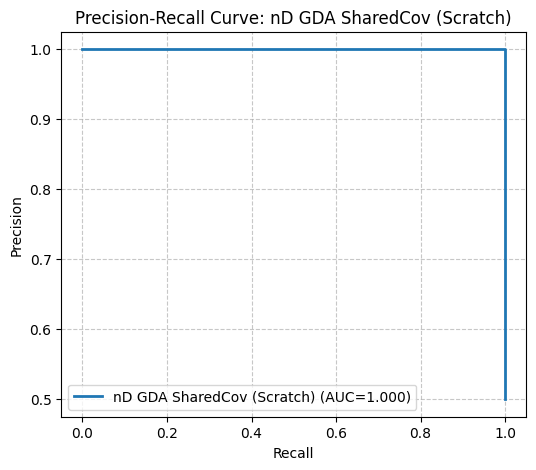

AUC = 1.0000


np.float64(1.0)

In [10]:
# =====================================================
#  2 — nD 2-CLASS GDA
# =====================================================

print("\n" + "="*70)
print("TASK 2: nD 2-CLASS GDA")
print("="*70)

X_nd = X_iris_binary.values
y_nd = y_iris_binary

#gda_full = GDA_nD().fit(X_nd, y_nd)
gda_full = GDA_LDA_SharedCov().fit(X_nd, y_nd)
for c, s in gda_full.stats_.items():
    print(f"Class {c}: μ={np.round(s['mu'],3)}, π={s['prior']:.3f}")

# task2_report = run_cross_validation(GDA_nD(), X_nd, y_nd, "nD GDA (Scratch)")
# plot_pr_curve(GDA_nD(), X_nd, y_nd, "nD GDA (Scratch)")
task2_report = run_cross_validation(GDA_LDA_SharedCov(), X_nd, y_nd, "nD GDA SharedCov (Scratch)")
plot_pr_curve(GDA_LDA_SharedCov(), X_nd, y_nd, "nD GDA SharedCov (Scratch)")



In [11]:
# =====================================================
#  3 — nD k-CLASS GDA
# =====================================================

print("\n" + "="*70)
print("TASK 3: nD k-CLASS GDA")
print("="*70)

X_kd = X_iris_multiclass
y_kd = y_iris_multiclass
# task3_report = run_cross_validation(GDA_nD(), X_kd, y_kd, "k-Class GDA (Scratch)")

task3_report = run_cross_validation(GDA_LDA_SharedCov(), X_kd, y_kd, "k-Class GDA SharedCov (Scratch)")



TASK 3: nD k-CLASS GDA
--- Running 10-Fold Cross-Validation for: k-Class GDA SharedCov (Scratch) ---
Confusion Matrix (Aggregated):
[[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]
Accuracy:  0.9733 ± 0.0442
Precision: 0.9756 ± 0.0424
Recall:    0.9733 ± 0.0442
F1-Score:  0.9732 ± 0.0443
----------------------------------------------------------------------------


In [12]:
# =====================================================
#  4 — Bernoulli NB
# =====================================================

print("\n" + "="*70)
print("TASK 4: BERNOULLI NAIVE BAYES")
print("="*70)

task4_report = run_cross_validation(BernoulliNaiveBayes(), X_spam_binary, y_spam_binary,
                                    "Bernoulli NB (Scratch)")




TASK 4: BERNOULLI NAIVE BAYES
--- Running 10-Fold Cross-Validation for: Bernoulli NB (Scratch) ---
Confusion Matrix (Aggregated):
[[2596  192]
 [ 334 1479]]
Accuracy:  0.8857 ± 0.0126
Precision: 0.8855 ± 0.0221
Recall:    0.8158 ± 0.0189
F1-Score:  0.8490 ± 0.0164
-------------------------------------------------------------------


In [13]:
# =====================================================
#  5 — Multinomial NB
# =====================================================

print("\n" + "="*70)
print("TASK 5: MULTINOMIAL NAIVE BAYES")
print("="*70)

task5_report = run_cross_validation(MultinomialNaiveBayes(), X_spam_counts, y_spam_binary,
                                    "Multinomial NB (Scratch)")




TASK 5: MULTINOMIAL NAIVE BAYES
--- Running 10-Fold Cross-Validation for: Multinomial NB (Scratch) ---
Confusion Matrix (Aggregated):
[[2301  487]
 [ 479 1334]]
Accuracy:  0.7900 ± 0.0303
Precision: 0.7335 ± 0.0429
Recall:    0.7358 ± 0.0392
F1-Score:  0.7343 ± 0.0376
---------------------------------------------------------------------


In [14]:
# =====================================================
#  6 — Comparison with sklearn
# =====================================================

print("\n" + "="*70)
print("TASK 6: BASELINE COMPARISONS")
print("="*70)

all_results = [task1_report, task2_report, task3_report, task4_report, task5_report]

lda_1d = run_cross_validation(LinearDiscriminantAnalysis(), X_1d, y_1d, "1D LDA (sklearn)")
lda_nd = run_cross_validation(LinearDiscriminantAnalysis(), X_nd, y_nd, "nD LDA (sklearn)")
lda_kd = run_cross_validation(LinearDiscriminantAnalysis(), X_kd, y_kd, "k-Class LDA (sklearn)")
bnb_sklearn = run_cross_validation(BernoulliNB(), X_spam_binary, y_spam_binary, "Bernoulli NB (sklearn)")
mnb_sklearn = run_cross_validation(MultinomialNB(), X_spam_counts, y_spam_binary, "Multinomial NB (sklearn)")

all_results.extend([lda_1d, lda_nd, lda_kd, bnb_sklearn, mnb_sklearn])

print("\nFINAL PERFORMANCE COMPARISON")
comparison_df = build_comparison_table(all_results)




TASK 6: BASELINE COMPARISONS
--- Running 10-Fold Cross-Validation for: 1D LDA (sklearn) ---
Confusion Matrix (Aggregated):
[[37 13]
 [13 37]]
Accuracy:  0.7400 ± 0.1685
Precision: 0.7517 ± 0.1733
Recall:    0.7400 ± 0.2375
F1-Score:  0.7283 ± 0.1819
-------------------------------------------------------------
--- Running 10-Fold Cross-Validation for: nD LDA (sklearn) ---
Confusion Matrix (Aggregated):
[[47  3]
 [ 1 49]]
Accuracy:  0.9600 ± 0.0490
Precision: 0.9500 ± 0.0764
Recall:    0.9800 ± 0.0600
F1-Score:  0.9616 ± 0.0473
-------------------------------------------------------------
--- Running 10-Fold Cross-Validation for: k-Class LDA (sklearn) ---
Confusion Matrix (Aggregated):
[[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]
Accuracy:  0.9733 ± 0.0442
Precision: 0.9756 ± 0.0424
Recall:    0.9733 ± 0.0442
F1-Score:  0.9732 ± 0.0443
------------------------------------------------------------------
--- Running 10-Fold Cross-Validation for: Bernoulli NB (sklearn) ---
Confusion Matrix (Aggreg

,Accuracy,Precision,Recall,F1-Score
Model,,,,
1D GDA (Scratch),0.7000,0.7550,0.6200,0.6596
nD GDA SharedCov (Scratch),0.9600,0.9500,0.9800,0.9616
k-Class GDA SharedCov (Scratch),0.9733,0.9756,0.9733,0.9732
Bernoulli NB (Scratch),0.8857,0.8855,0.8158,0.8490
Multinomial NB (Scratch),0.7900,0.7335,0.7358,0.7343
1D LDA (sklearn),0.7400,0.7517,0.7400,0.7283
nD LDA (sklearn),0.9600,0.9500,0.9800,0.9616
k-Class LDA (sklearn),0.9733,0.9756,0.9733,0.9732
Bernoulli NB (sklearn),0.8857,0.8855,0.8158,0.8490


In [15]:
# =====================================================
#  7 — Reflection
# =====================================================

reflection = """
Implementing Gaussian Discriminant Analysis and Naive Bayes from scratch
connected theoretical probability models to real-world datasets.
Each generative model learned explicit parameters from data distributions
and achieved comparable performance to sklearn baselines.

Key observations:
• 1D and nD GDA models captured Gaussian separability effectively.
• Regularization in covariance estimation prevented singular matrices.
• Bernoulli and Multinomial NB worked well on discrete Spambase data.
• Cross-validation revealed realistic performance variability across folds.
• Comparing with sklearn verified implementation correctness.

Lessons learned:
Always separate training and testing to avoid optimistic bias.
Stabilize numeric computations for covariance inversion and log-space
probabilities. Manual implementation deepens conceptual understanding.
"""
print(reflection)



Implementing Gaussian Discriminant Analysis and Naive Bayes from scratch
connected theoretical probability models to real-world datasets.
Each generative model learned explicit parameters from data distributions
and achieved comparable performance to sklearn baselines.

Key observations:
• 1D and nD GDA models captured Gaussian separability effectively.
• Regularization in covariance estimation prevented singular matrices.
• Bernoulli and Multinomial NB worked well on discrete Spambase data.
• Cross-validation revealed realistic performance variability across folds.
• Comparing with sklearn verified implementation correctness.

Lessons learned:
Always separate training and testing to avoid optimistic bias.
Stabilize numeric computations for covariance inversion and log-space
probabilities. Manual implementation deepens conceptual understanding.

